In [59]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans

## Getting DMC colors from web

In [60]:
# scrape dmc colors
response = requests.get('https://dmc.crazyartzone.com')
soup = BeautifulSoup(response.content, "html.parser")

In [63]:
table_rows = soup.find_all("tr")
table_rows = list(filter(lambda x: len(x) == 6,map(lambda r: r.get_text().strip().split('\n'),table_rows)))

# dmc colors dictionary
dmc = {rows[0]: [int(rows[3]), int(rows[4]), int(rows[5]), rows[1], rows[0]] for rows in table_rows}

## Utilities

In [69]:
def reduce_color_count(image, desired_colors):
    image_array = np.array(image)
    pixel_values = image_array.reshape(-1, 3)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=desired_colors, n_init='auto')
    kmeans.fit(pixel_values)

    # Replace pixel values with cluster centers
    quantized_colors = kmeans.cluster_centers_[kmeans.labels_]
    
    # Reshape the quantized colors array back to the original shape
    quantized_image_array = quantized_colors.reshape(image_array.shape)

    # Create a PIL image from the quantized colors array
    quantized_image = Image.fromarray(quantized_image_array.astype('uint8'))

    return quantized_image

def euclidean_distance_corrected(c1, c2):
    (r1, g1, b1, _, _) = c1
    (r2, g2, b2) = c2
    # return (r1-r2)**2 + (g1-g2)**2 + (b1-b2)**2
    return 2 * ((r1-r2)**2) + 4*((g1-g2)**2) + 3*((b1-b2)**2)

def get_dmc(colour):
    temp_dist = 99999999
    code = ''
    for key in dmc:
        dist = euclidean_distance_corrected(dmc[key], colour)
        if dist < temp_dist:
            code = key
            temp_dist = dist
    return dmc[code]
        
def convert2dmc( colour):
    dmc_item = get_dmc(colour)
    return (dmc_item[0], dmc_item[1], dmc_item[2])

In [70]:
class SVG:    
    xml = ''
    def __init__(self, black_white = False, minor_lines = False, symbols = True):
        self.black_white = black_white
        self.minor_lines = minor_lines
        self.symbols = symbols
        
    def get_rgb_from_dmc_item(self, item):
        return 'rgb('+str(item[0])+','+str(item[1])+','+str(item[2])+');'

    def gen_glyph(self, num, x, y, s = 1):
        x = str(x)
        y = str(y)
        scale = 'scale(' + str(s) + ')'
        if num == 0:
            return "<path class='glyph' d='M4 4L16 16' transform='translate("+x+" "+y+") "+scale+"'/>" # backslash
        elif num == 1:
            return "<path class='glyph' d='M4 16L16 4M4 10L 16 10' transform='translate("+x+" "+y+") "+scale+"'/>" # forward slash
        elif num == 2:
            return "<path class='glyph' d='M7 7L7 13 13 13 13 7Z' fill='black' transform='translate("+x+" "+y+") "+scale+"'/>" # little square, filled black
        elif num == 3:
            return "<path class='glyph' d='M4 4L10 16L16 4 Z' transform='translate("+x+" "+y+") "+scale+"'/>" # triangle, upside down
        elif num == 4:
            return "<path class='glyph' d='M4 4L16 16M4 16 L16 4' transform='translate("+x+" "+y+") "+scale+"'/>" # diagonal cross
        elif num == 5:
            return "<path class='glyph' d='M4 4L4 16 16 16 16 4Z' transform='translate("+x+" "+y+") "+scale+"'/>" # square
        elif num == 6:
            return "<path class='glyph' d='M4 4L10 16L16 4 Z' fill='black' transform='translate("+x+" "+y+") "+scale+"'/>" # triangle, upside down, filled black
        elif num == 7:
            return "<path class='glyph' d='M10 4L6 10 10 16 14 10Z' fill='black' transform='translate("+x+" "+y+") "+scale+"'/>" # diamond, filled black
        elif num == 8:
            return "<path class='glyph' d='M8 8L8 12 12 12 12 8Z' transform='translate("+x+" "+y+") "+scale+"'/>" # little square
        elif num == 9:
            return "<path class='glyph' d='M4 4L16 16M4 16 L16 4M10 4L10 16M4 10L16 10' transform='translate("+x+" "+y+") "+scale+"'/>" # 8 way cross
        elif num == 10:
            return "<path class='glyph' d='M4 4L4 16 16 16 16 4Z' fill='black' transform='translate("+x+" "+y+") "+scale+"'/>" # square, filled black
        else:
            return ''

    def add_rect(self, palette, index, x, y, size):
        glyph_scale = size / 20.0
        fill = 'fill:rgb(255,255,255);' if self.black_white else 'fill:'+self.get_rgb_from_dmc_item(palette[index])
        stroke = 'stroke:rgb(20,20,20);stroke-width:1;' if self.minor_lines else 'stroke:none;'
        sym = self.gen_glyph(index, x, y, glyph_scale) if self.symbols else ''
        self.xml += '<rect x="'+str(x)+'" y="'+str(y)+'" width="'+str(size)+'" height="'+str(size)+'" style="'+fill+stroke+'"/>' + sym
        
    def prep_for_drawing(self, width, height):
        self.xml += '<svg xmlns="http://www.w3.org/2000/svg" width="'+str(width)+'" height="'+str(height)+'" style ="fill:none;">'
        self.xml += '<style>.svg_txt{font-size:20px;}.glyph{stroke:#000000;stroke-width:1;stroke:1;}</style>'
    
    def mid_arrows(self, size, width, height):
        h = str(size/2)
        f = str(size)
        self.xml += "<path d=\"M0 "+h+"L"+f+" "+h+"M"+h+" 0L"+f+" "+h+" "+h+" "+f+"\" stroke=\"black\" stroke-width=\"2\" fill=\"none\" transform='translate(0 " + str(height/2) + ")'/>"
        self.xml += "<path d=\"M"+h+" 0L"+h+" "+f+" M"+f+" "+h+"L"+h+" "+f+" 0 "+h+"\" stroke=\"black\" stroke-width=\"2\" fill=\"none\" transform='translate(" + str(width/2) + " 0)'/>"
    
    def major_gridlines(self, size, width, height):
        for x in range(size + size * 10, width, size * 10):
            self.xml += "<line x1=\"" + str(x) + "\" y1=\"" + str(size) + "\" x2=\"" + str(x) + "\" y2=\"" + str(height) + "\" style=\"stroke:black;stroke-width:2\" />"
        for y in range(size + size * 10, height, size * 10):
            self.xml += "<line x1=\"" + str(size) + "\" y1=\"" + str(y) + "\" x2=\"" + str(width) + "\" y2=\"" + str(y) + "\" style=\"stroke:black;stroke-width:2\" />"
            
    def add_key_colour(self, x, y, size, index, colour):
        # key
        glyph_scale = size / 20.0
        fill = 'fill:rgb(255,255,255);' if self.black_white else 'fill:rgb('+str(colour[0])+', '+str(colour[1])+', '+str(colour[2])+');'
        stroke = 'stroke:rgb(20,20,20);stroke-width:1;' if self.minor_lines else 'stroke:none;'
        sym = self.gen_glyph(index, x, y, glyph_scale) if self.symbols else ''
        self.xml += '<rect x="0" y="'+str(y)+'" width="'+str(size)+'" height="'+str(size)+'" style="'+fill+stroke+'"/>' + sym
        # colour name
        self.xml += '<rect x="'+str(size)+'" y="'+str(y)+'" width="'+str(size* 10)+'" height="'+str(size)+'" style="fill:rgb(255,255,255);stroke:black;stroke-width:1;"/>'
        self.xml += '<text x = "' + str(x + size * 1.5) + '" y = "' + str(y + size / 2.0) + '" fill="black">' + colour[3] + '</text>'
        # colour code
        self.xml += '<rect x="'+str(size*11)+'" y="'+str(y)+'" width="'+str(size* 2)+'" height="'+str(size)+'" style="fill:rgb(255,255,255);stroke:black;stroke-width:1;"/>'
        self.xml += '<text x = "' + str(size* 11 + (size/2.0)) + '" y = "' + str(y + size / 2.0) + '" fill="black">' + colour[4] + '</text>'
        
    def save(self, filename):
        self.xml += '</svg>'
        f = open(filename,'w')
        f.write(self.xml)
        f.close()
        

## Loading the image

In [71]:
input_file_name = 'olive.jpg'    # input file name, has to be a jpg
num_colors = 16                  # number of colors to use in the pattern
stitches_count_x = 100           # stitch count, number of stitches in x axis
stitches_count_y = 100           # stitch count, number of stitches in x axis

border_px = 54
stitch_h = 25
stitch_w = 25
inner_box_offset = 5
im = Image.open(input_file_name)
assert im.width == 2 * border_px + stitches_count_x * stitch_w
assert im.height == 2 * border_px + stitches_count_y * stitch_h

## Pixelating the image into a defined set of colors

In [72]:
# removing the borders from the olive image.
im = im.crop((border_px,border_px,im.width - border_px,im.height - border_px))

In [73]:
# reducing the image to a 100X100 pixel image where each pixel is the average pixel value of a 15X15 box inside every 25X25 stitch box.
dmc_image = Image.new('RGB', (stitches_count_x, stitches_count_y))

for i in range(stitches_count_x):
    for j in range(stitches_count_y):
        x1 = i * stitch_w + inner_box_offset # +5 pixel so that the averaging is applied to an inner 15X15 box of every 25X25 box.
        y1 = j * stitch_h + inner_box_offset
        x2 = (i + 1) * stitch_w - inner_box_offset
        y2 = (j + 1) * stitch_h - inner_box_offset
        inner_box = im.crop((x1, y1, x2, y2))

        # Calculate the average RGB values
        average_rgb = (
            int(sum([pixel[0] for pixel in inner_box.getdata()]) / (inner_box.height * inner_box.width)),
            int(sum([pixel[1] for pixel in inner_box.getdata()]) / (inner_box.height * inner_box.width)),
            int(sum([pixel[2] for pixel in inner_box.getdata()]) / (inner_box.height * inner_box.width))
        )

        # Assign the average RGB value to the corresponding pixel
        dmc_image.putpixel((i, j), average_rgb)

dmc_image = reduce_color_count(dmc_image,num_colors)
dmc_image = dmc_image.convert('P', palette=Image.ADAPTIVE, colors = num_colors)

In [82]:
dmc_image.save('olive_pixelated.png')

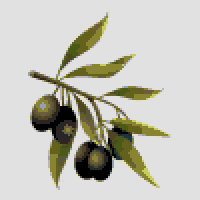

In [81]:
dmc_image.resize((200,200))

In [58]:
x_count = dmc_image.size[0]
y_count = dmc_image.size[1]
svg_pattern = [[dmc_image.getpixel((x, y)) for x in range(x_count)] for y in range(y_count)]

palette = dmc_image.getpalette()
svg_palette = [get_dmc((palette[i * 3], palette[i * 3 + 1], palette[i * 3 + 2])) for i in range(num_colors)]


def get_neighbors(pos, matrix):
    rows = len(matrix)
    cols = len(matrix[0]) if rows else 0
    width = 1
    for i in range(max(0, pos[0] - width), min(rows, pos[0] + width + 1)):
        for j in range(max(0, pos[1] - width), min(cols, pos[1] + width + 1)):
            if not (i == pos[0] and j == pos[1]):
                yield matrix[i][j]
    

# black_white, minor, symbols    
col_sym = SVG(False, True, True)
blw_nsy = SVG(True, True, True)
col_nsy = SVG(False, False, False)
key = SVG(False, True, True)

for x in range(0, x_count):
    for y in range(0, y_count):
        gen = get_neighbors([y, x], svg_pattern)
        neighbors = []
        for n in gen:
            neighbors += [n]
        if svg_pattern[y][x] not in neighbors:
            mode = max(neighbors, key=neighbors.count)
            svg_pattern[y][x] = mode

# 8

svg_cell_size = 10
width = x_count * svg_cell_size
height = y_count * svg_cell_size
col_sym.prep_for_drawing(width, height)
col_sym.mid_arrows(svg_cell_size, width, height)
blw_nsy.prep_for_drawing(width, height)
blw_nsy.mid_arrows(svg_cell_size, width, height)
col_nsy.prep_for_drawing(width, height)
x = y = svg_cell_size # to allow drawing of midpoint arrows
for row in svg_pattern:
    for colour_index in row:
        col_sym.add_rect(svg_palette, colour_index, x, y, svg_cell_size)
        blw_nsy.add_rect(svg_palette, colour_index, x, y, svg_cell_size)
        col_nsy.add_rect(svg_palette, colour_index, x, y, svg_cell_size)
        x += svg_cell_size
    y += svg_cell_size
    x = svg_cell_size
blw_nsy.major_gridlines(svg_cell_size, width, height)
col_sym.major_gridlines(svg_cell_size, width, height)

# 9

size = 40
key.prep_for_drawing(size * 13, size * len(svg_palette))
x = y = 0
for i in range(len(svg_palette)):
    key.add_key_colour(x, y, size, i, svg_palette[i])
    y += size

col_sym.save('col_sym.svg')
blw_nsy.save('blw_sym.svg')
col_nsy.save('col_nsy.svg')
key.save('key.svg')